In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
from scripts.AutoEncoder import AutoEncoder, AutoEncoderDataset, Encoder, Decoder
from scripts.utils import train_keys, target_keys, ScaleData

In [3]:
train = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
df_train = pd.read_pickle(train)
df_train = df_train[train_keys]
df_train, scaler = ScaleData(df_train)

df_train.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07
mean,-7.554751e-17,2.325436e-16,-1.969976e-14,-2.478637e-14,-1.175991e-15,-7.503728e-15,4.034983e-14,-3.315205e-15,-1.910605e-15,4.421118e-16,-5.968948e-16,2.790048e-16,2.490396e-15,1.438155e-14,1.090860e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.249306e+02,-3.814446e+02,-7.457400e+01,-2.143341e+00,-1.921246e+00,-1.297033e+00,-1.710608e+02,-1.277790e+00,-8.474415e+01,-2.678420e+01,-5.509811e+01,-2.109354e+02,-1.799047e+00,-3.488317e+00,-3.060594e+00
25%,-3.258431e-02,-2.497779e-01,-2.199693e-01,-5.673091e-01,-7.880002e-01,-7.826355e-01,1.095864e-04,-7.187233e-01,-5.207354e-01,-3.142720e-01,-1.510736e-01,-1.056034e-01,-2.791258e-01,-1.170805e-01,-7.257788e-01
50%,-1.714946e-02,-1.156905e-01,-2.199693e-01,-5.673091e-01,4.251098e-02,-1.509808e-01,1.095864e-04,-2.630268e-01,-2.760170e-01,-2.158643e-01,-9.455876e-02,-4.192553e-02,-2.264989e-01,-8.693051e-02,-1.606022e-01
75%,5.464286e-03,6.980049e-02,1.017680e-01,3.190794e-01,8.328257e-01,5.075416e-01,1.095864e-04,4.315107e-01,2.244570e-01,6.491163e-02,-1.128275e-02,3.915007e-02,-6.719322e-02,-8.693051e-02,5.922162e-01
max,2.249695e+02,3.585519e+02,5.236406e+01,5.679170e+00,1.572247e+00,1.505446e+01,1.710611e+02,2.417821e+01,2.851771e+02,1.440235e+02,6.117973e+01,2.106058e+02,2.036316e+01,1.787184e+01,8.109160e+00


In [4]:
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl"

n = 10_000
df_test = pd.read_pickle(test)
target = df_test['target']

df_test_good = df_test[df_test.target == 1]
df_test_good = df_test_good[train_keys]
df_test_good,_ = ScaleData(df_test_good, scaler)

df_test_bad = df_test[df_test.target == 0]
df_test_bad = df_test_bad[train_keys]
df_test_bad,_ = ScaleData(df_test_bad, scaler)

df_test_good.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06
mean,-1.313159e-03,-6.508701e-02,-3.056929e-02,-2.083342e-02,-1.719769e-01,-4.291065e-02,1.095851e-04,-9.875633e-02,-5.404577e-02,-7.175191e-02,-3.352064e-02,-3.432134e-02,-2.017526e-02,8.270491e-03,5.854952e-02
std,7.492465e-02,3.810324e-01,6.460341e-01,1.027985e+00,1.037651e+00,9.862200e-01,3.015037e-08,9.606764e-01,7.628097e-01,5.478643e-01,3.398238e-01,1.620698e-01,9.775303e-01,8.786466e-01,9.967844e-01
min,-1.040125e+00,-2.579476e+00,-1.226910e+01,-2.143341e+00,-1.921246e+00,-1.297033e+00,1.087983e-04,-1.277790e+00,-1.737223e+00,-2.418397e+00,-5.267125e+00,-1.269895e+00,-1.799047e+00,-3.488317e+00,-3.060594e+00
25%,-3.159543e-02,-2.812023e-01,-2.199693e-01,-5.673091e-01,-1.171131e+00,-8.289429e-01,1.095864e-04,-8.066419e-01,-5.521025e-01,-3.321236e-01,-1.522355e-01,-1.230394e-01,-2.833176e-01,-8.693051e-02,-6.649833e-01
50%,-1.630066e-02,-1.648249e-01,-2.199693e-01,-5.673091e-01,-3.164967e-01,-1.951416e-01,1.095864e-04,-3.754658e-01,-3.525283e-01,-2.550817e-01,-9.976217e-02,-7.479854e-02,-2.275223e-01,-8.693051e-02,-7.581535e-02
75%,5.906990e-03,1.546105e-02,-4.718065e-02,1.361700e-01,7.991160e-01,4.557147e-01,1.095864e-04,3.243114e-01,1.601262e-01,-2.735723e-02,-1.741613e-02,8.418407e-03,-1.141344e-01,-8.693051e-02,6.418878e-01
max,1.028327e+00,4.093519e+00,1.885319e+01,5.679170e+00,1.572247e+00,1.505446e+01,1.099808e-04,2.417821e+01,5.147397e+00,1.014823e+01,4.877820e+00,2.045406e+00,2.036316e+01,1.787184e+01,7.008683e+00


## AE trained on all clipped input points

In [5]:
path = glob.glob("/share/rcifdata/jbarr/UKAEAGroupProject/logs/AutoEncoder/Run-13/*")[0]

model = AutoEncoder.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 150, learning_rate = 0.0025)
encoder = model.encoder

### Evaluate on inputs that give outputs

In [6]:
data_good = torch.from_numpy(df_test_good.values).float()
outputs_good = encoder.forward(data_good).detach().numpy()

<IPython.core.display.Javascript object>


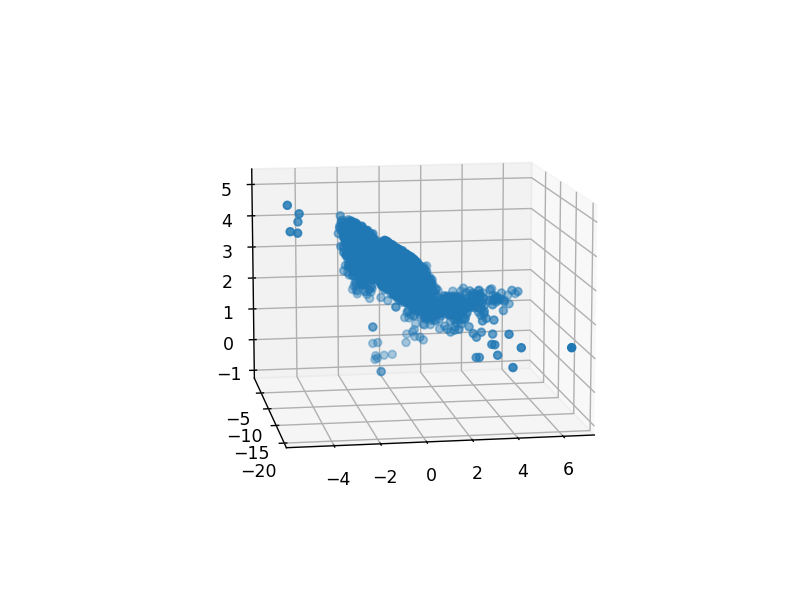

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_good[:n,0], outputs_good[:n,1],outputs_good[:n,2])
fig.show()

<IPython.core.display.Javascript object>


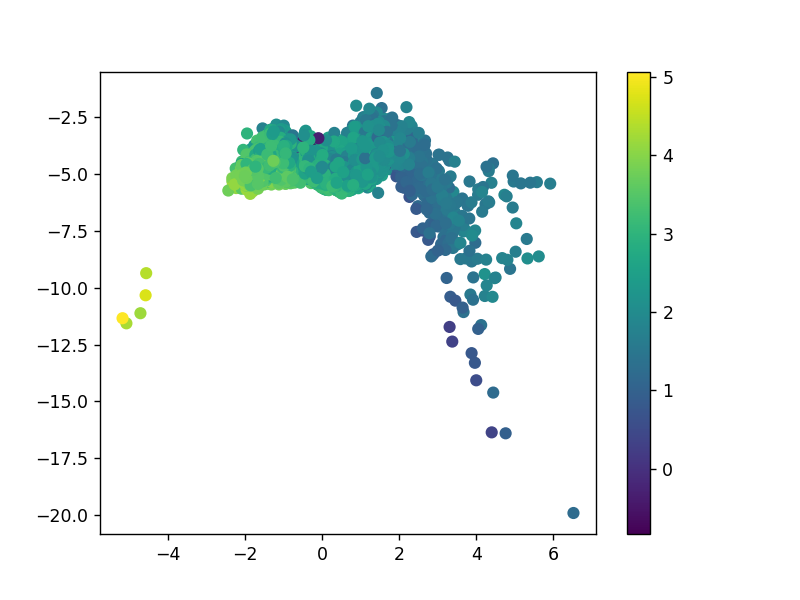

In [12]:
plt.figure()

sc = plt.scatter(outputs_good[:n,0], outputs_good[:n,1], c = outputs_good[:n,2])
#plt.xlim(-20,20)
#plt.ylim(-50,0)
plt.colorbar(sc)
plt.show()

### Plot  input and output distributions

In [9]:
AE_output = model.forward(data_good).detach().numpy()
df_ae_output = pd.DataFrame(AE_output, columns = train_keys)
df_ae_output['AE'] = 'Outputs'

df_test_tmp = df_test_good
df_test_tmp['AE'] = 'Inputs'

In [10]:
df_compare = pd.concat([df_ae_output, df_test_tmp], ignore_index=True)
df_compare_sample = df_compare.sample(n)

<IPython.core.display.Javascript object>


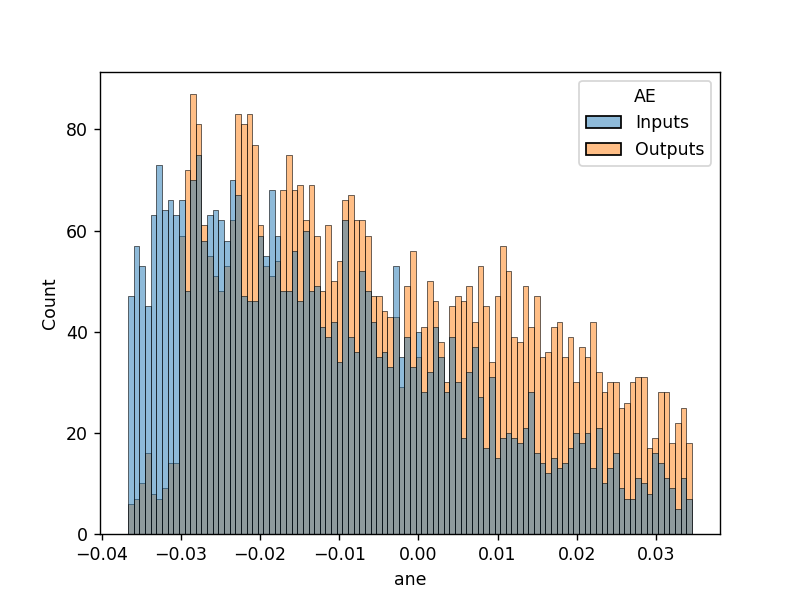

<IPython.core.display.Javascript object>


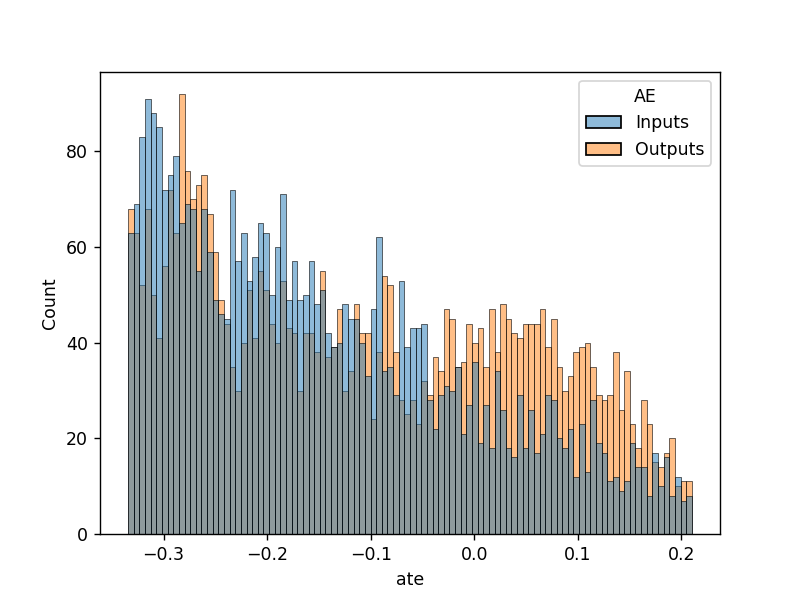

<IPython.core.display.Javascript object>


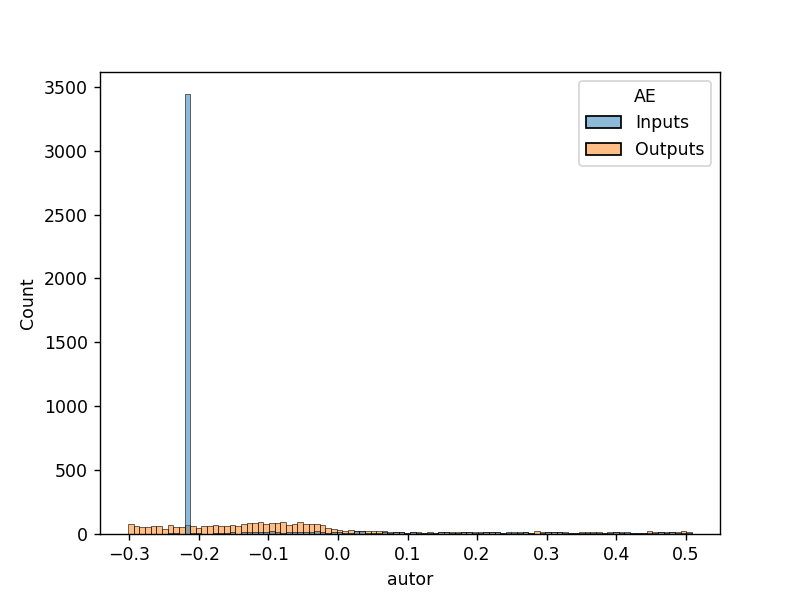

<IPython.core.display.Javascript object>


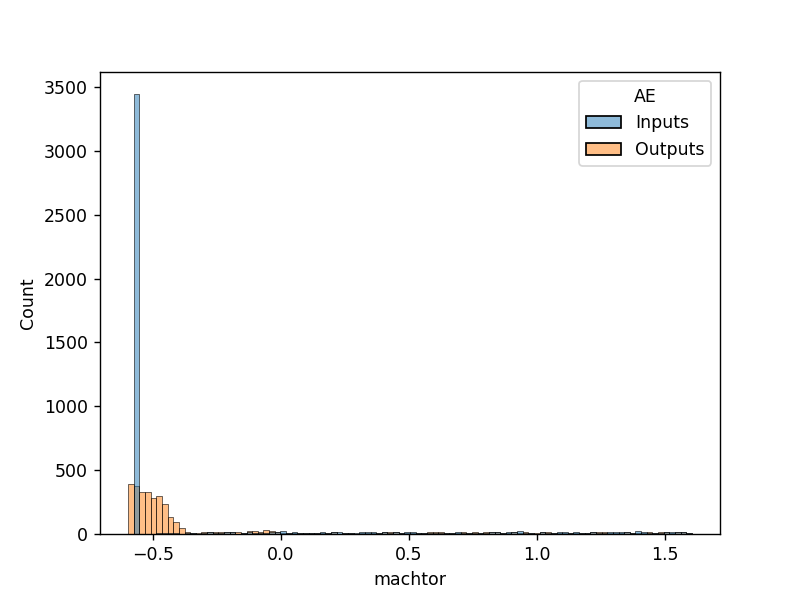

<IPython.core.display.Javascript object>


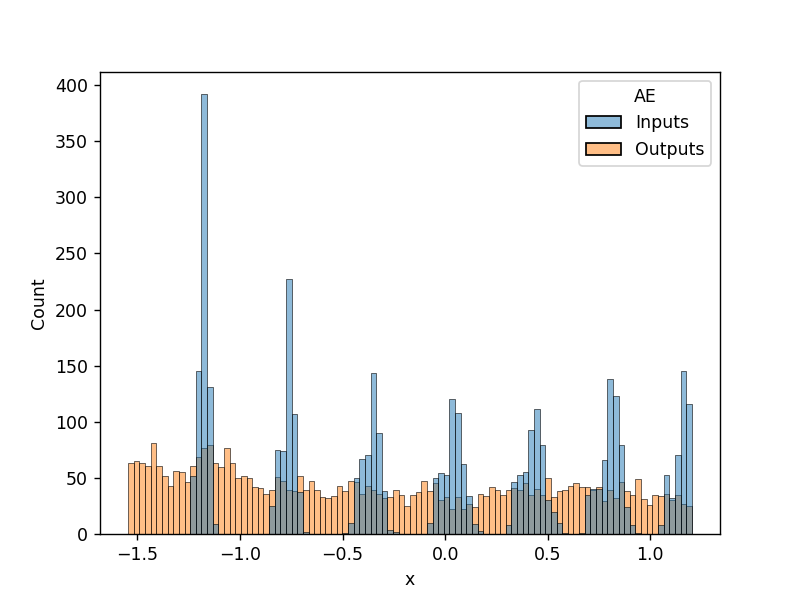

<IPython.core.display.Javascript object>


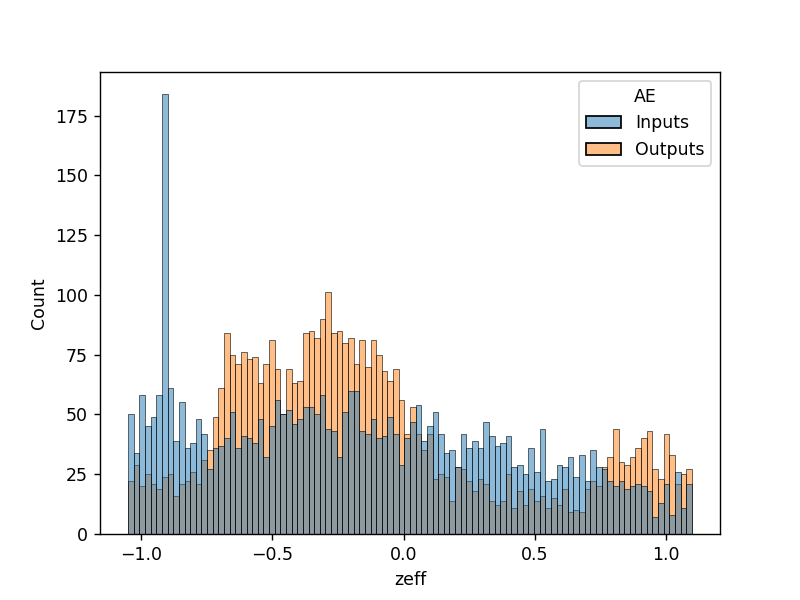

<IPython.core.display.Javascript object>


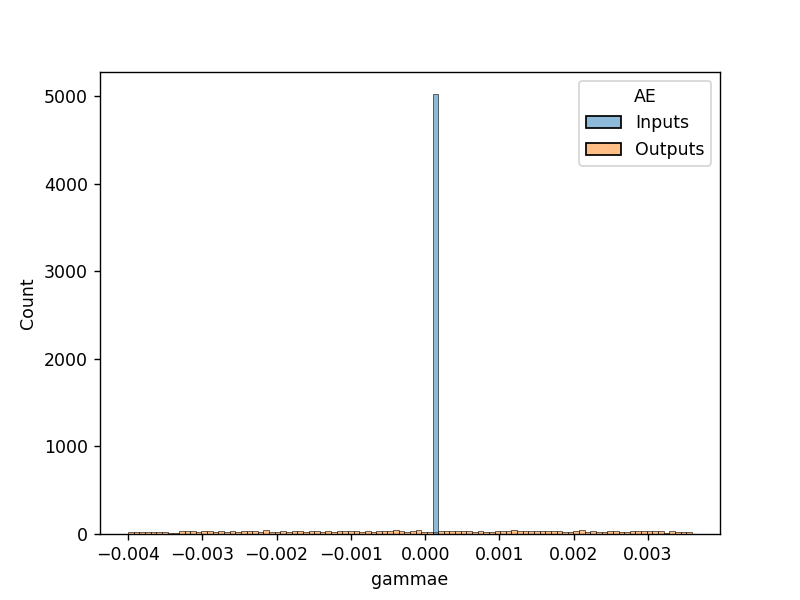

<IPython.core.display.Javascript object>


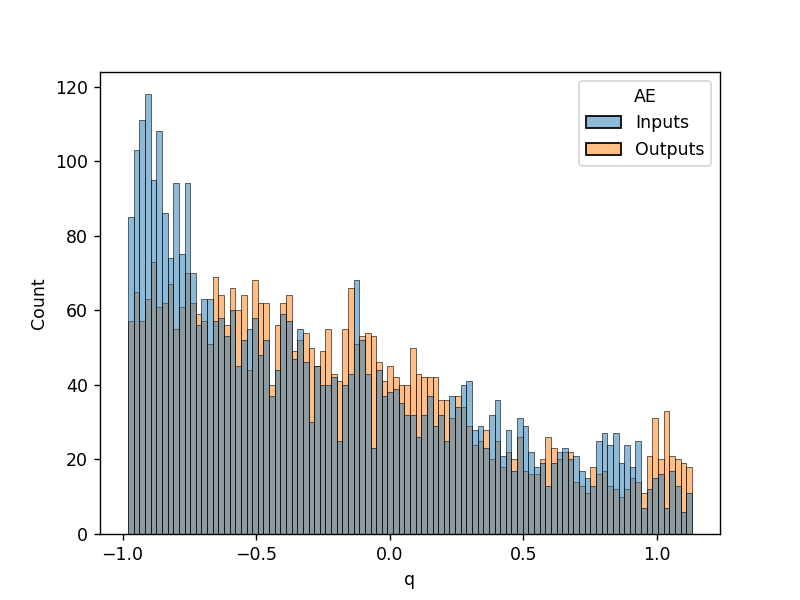

<IPython.core.display.Javascript object>


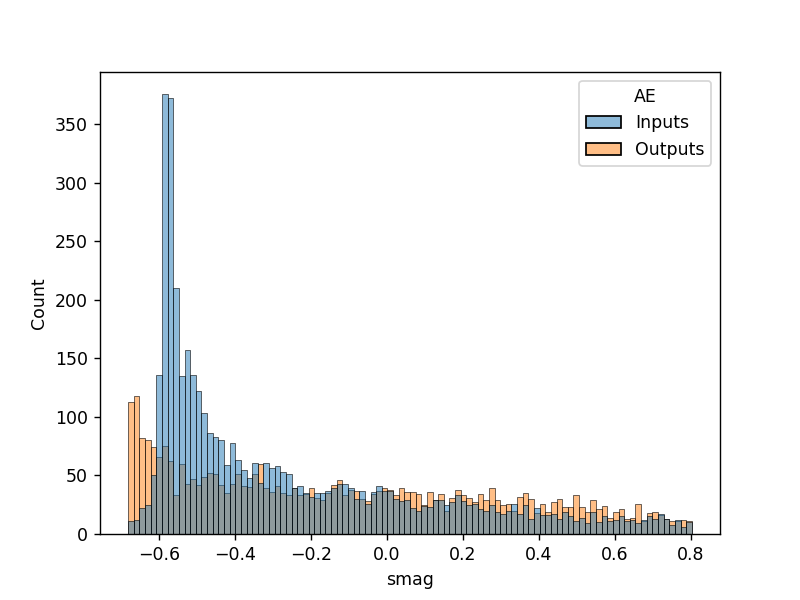

<IPython.core.display.Javascript object>


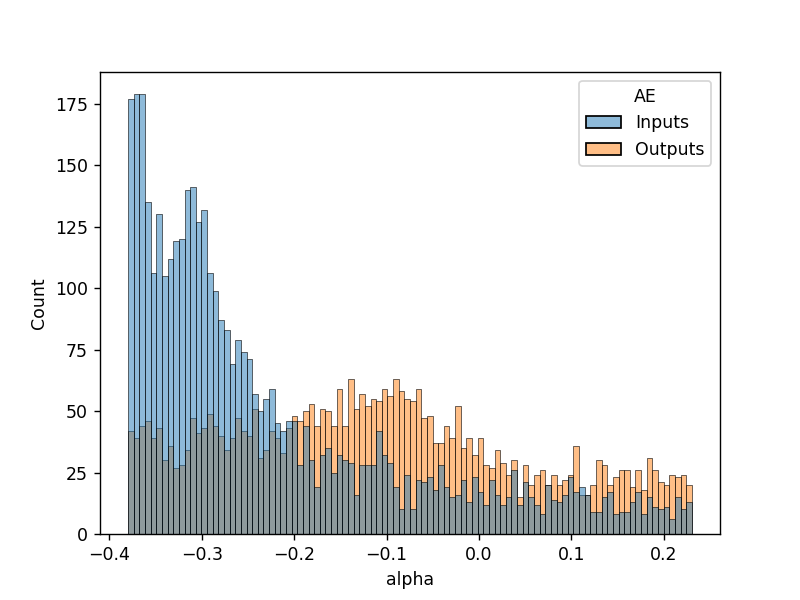

<IPython.core.display.Javascript object>


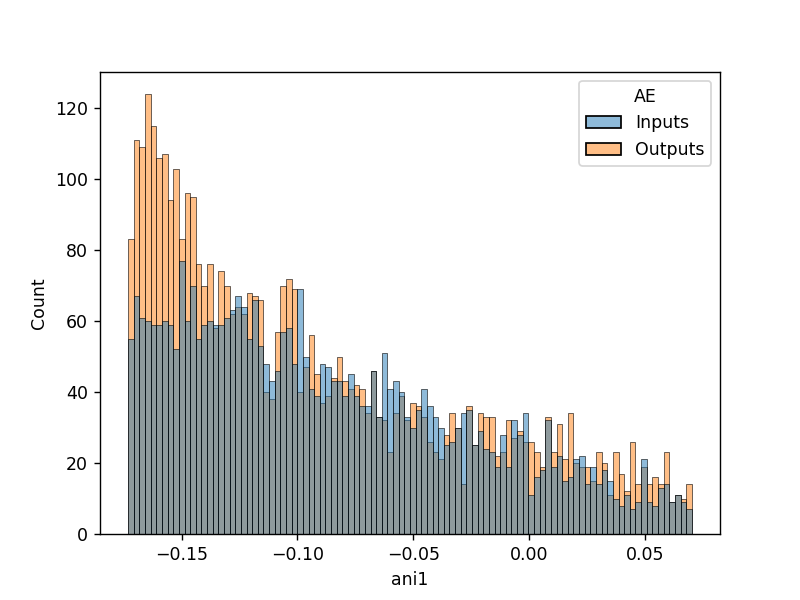

<IPython.core.display.Javascript object>


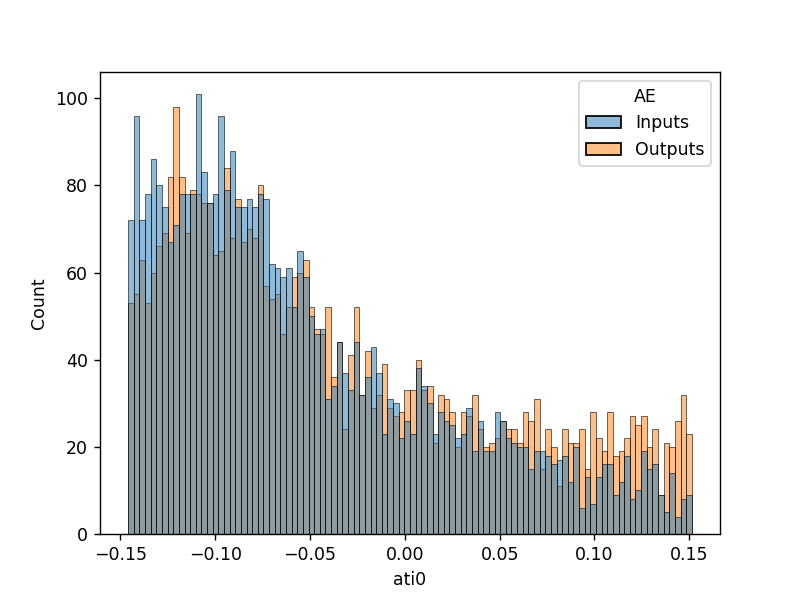

<IPython.core.display.Javascript object>


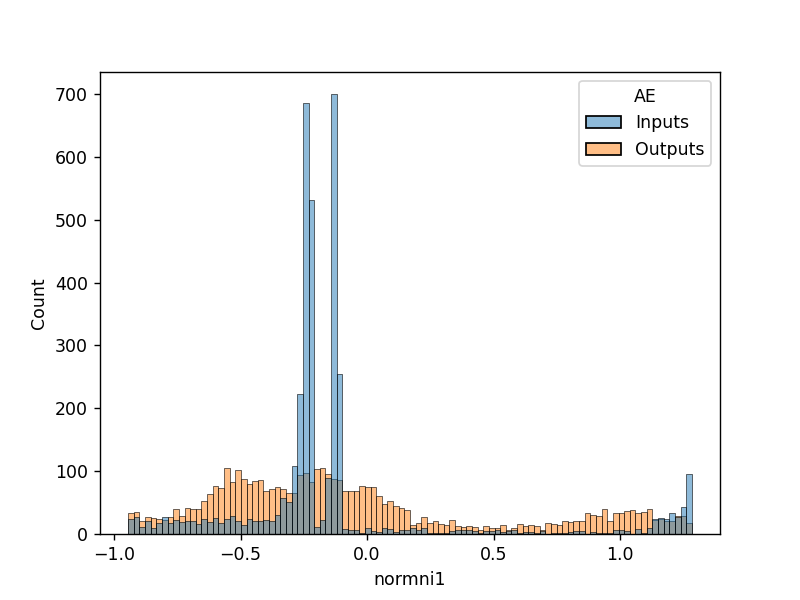

<IPython.core.display.Javascript object>


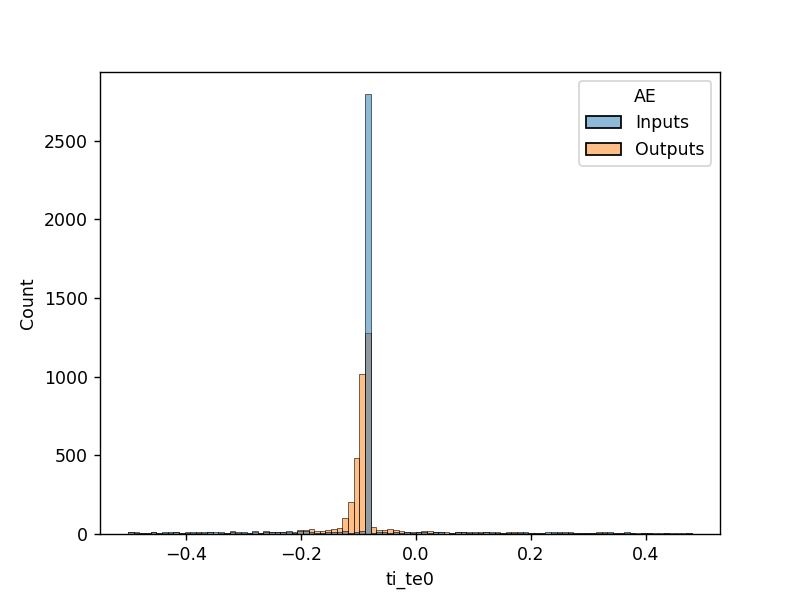

<IPython.core.display.Javascript object>


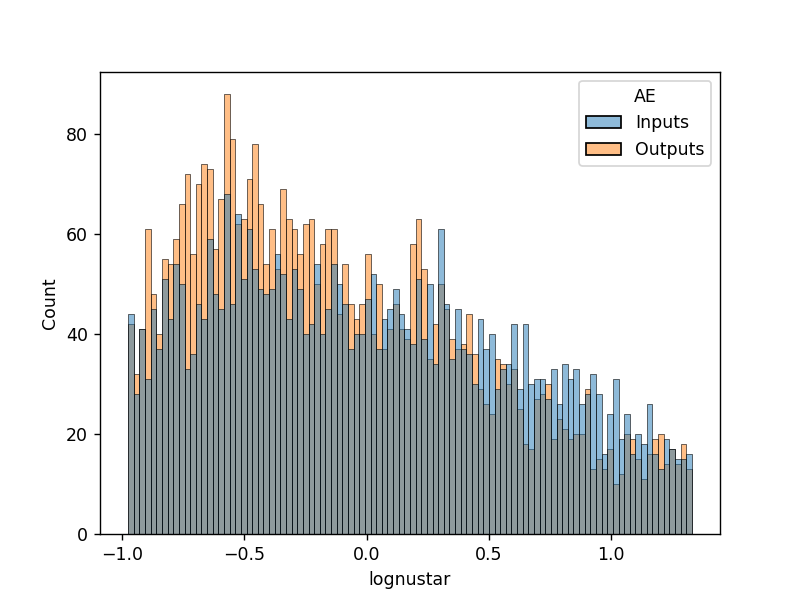

In [11]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample[i].quantile(0.1)
    x_max = df_compare_sample[i].quantile(0.9)
    sns.histplot(data = df_compare_sample, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)

### Evaluate on inputs that don't give outputs

In [13]:
data_bad = torch.from_numpy(df_test_bad.values).float()
outputs_bad = encoder.forward(data_bad).detach().numpy()

<IPython.core.display.Javascript object>


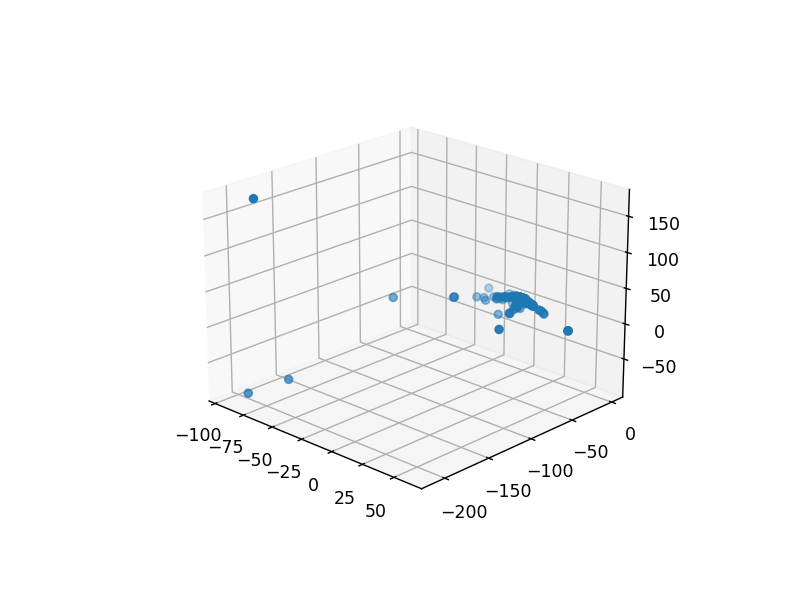

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_bad[:n,0], outputs_bad[:n,1],outputs_bad[:n,2])
fig.show()

<IPython.core.display.Javascript object>


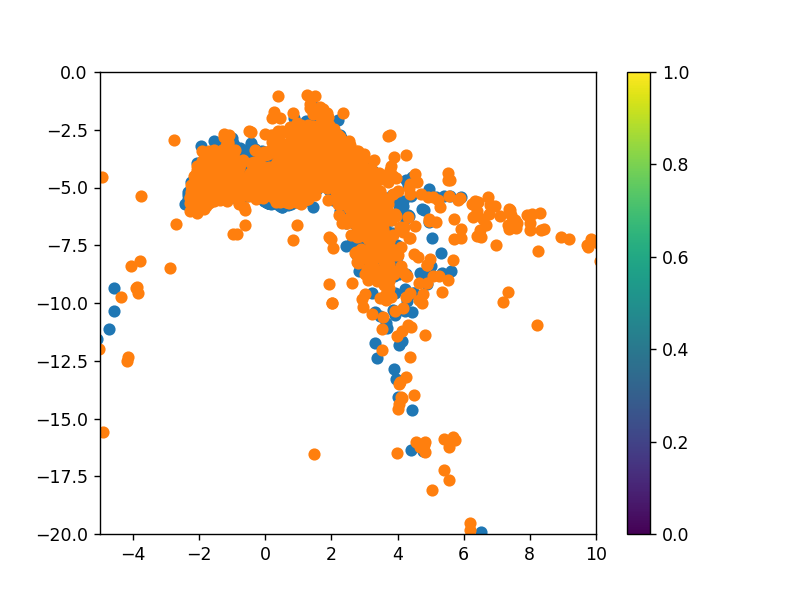

In [41]:
plt.figure()
#sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
#plt.colorbar(sc)
plt.scatter(outputs_good[:n,0], outputs_good[:n,1],) #c = outputs_good[:n,2])
plt.scatter(outputs_bad[:n,0], outputs_bad[:n,1], )#c = outputs_bad[:n,2])
plt.xlim(-5,10)
plt.ylim(-20,0)
plt.colorbar()

plt.show()

<IPython.core.display.Javascript object>


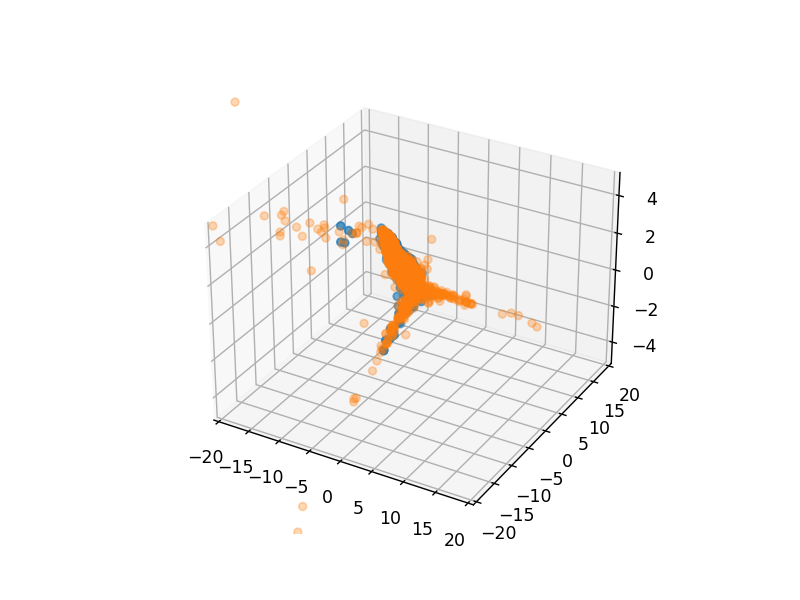

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(outputs_good[:n,0], outputs_good[:n,1],outputs_good[:n,2])
ax.scatter(outputs_bad[:n,0], outputs_bad[:n,1],outputs_bad[:n,2])
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_zlim(-5,5)

fig.show()



In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [29]:
df_1 = pd.DataFrame(data = outputs_good)
df_1['target'] = 1

df_2 = pd.DataFrame(data = outputs_bad)
df_2['target'] = 0

df = pd.concat([df_1, df_2])

class_train, class_test = train_test_split(df)
class_train

,0,1,2,target
219850,1.590315,-3.939387,2.309516,1
519426,1.402653,-4.810933,2.113957,1
2065086,1.115908,-4.467867,1.763452,1
113369,-1.389303,-4.394540,3.341038,0
439045,-0.242747,-4.606622,2.282170,1
...,...,...,...,...
592993,1.478100,-4.261367,2.032872,1
1563218,-1.232245,-4.301448,2.804351,1
304720,-1.381837,-4.457212,3.417234,0
60598,1.584841,-4.377147,2.001351,0


In [32]:
#clf = LogisticRegression(C = 10, class_weight = 'balanced')
clf = RandomForestClassifier(n_estimators = 10, class_weight = 'balanced', verbose = 1)
clf.fit(class_train[[0, 1, 2]], class_train['target'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


RandomForestClassifier(class_weight='balanced', n_estimators=10, verbose=1)

In [33]:
preds = clf.predict(class_test[[0,1,2]])
tn, fp, fn, tp = confusion_matrix(class_test['target'], preds).ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.9s finished


In [34]:
print(tpr, tnr)

0.7749229411168835 0.5389647225669207


In [35]:
confusion_matrix(class_test['target'], preds, normalize = 'true')

array([[0.53896472, 0.46103528],
       [0.22507706, 0.77492294]])

In [36]:
print((tp + tn)/ (tp + tn + fp + fn))

0.6952078996351545
